<a href="https://colab.research.google.com/github/esb-index/Barka-AV/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p /content/era5_processed_light && mv /content/*_daily_light.csv /content/era5_processed_light/


In [ ]:
# --- 1️⃣ Importok ---
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from scipy.stats.mstats import winsorize

# --- 2️⃣ Beállítások ---
INPUT_PATH = "/content/"
OUTPUT_PATH = "/content/cpri_outputs/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# --- 3️⃣ Országok beolvasása ---
files = [f for f in os.listdir(INPUT_PATH) if f.endswith("_daily_merged.csv")]
print("Talált napi fájlok:", files)

# --- 4️⃣ Helper: winsorizálás + normalizálás ---
def winsorize_series(s):
    return winsorize(s, limits=[0.01, 0.01])

def normalize_series(s):
    return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else s*0

# --- 5️⃣ Feldolgozás ---
yearly_records = {"heatwave": [], "flood": [], "windstorm": []}

for f in tqdm(files):
    df = pd.read_csv(os.path.join(INPUT_PATH, f))
    country = f.split("_")[0].lower()

    # biztosítjuk, hogy legyen 'date' és 't2m', 'tp', 'u10', 'v10' oszlop
    if 'date' not in df.columns:
        df.rename(columns={c: 'date' for c in df.columns if 'time' in c.lower()}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year

    #  --- HEATWAVE: 2m_temp > 90. percentil ---
    if 't2m' in df.columns:
        t2m = df['t2m']
        thresh = np.nanpercentile(t2m, 90)
        df['heatwave_flag'] = (t2m > thresh).astype(int)
        hw_yearly = df.groupby('year').agg(
            H_raw=('t2m', 'mean'),
            P_raw=('heatwave_flag', 'sum')
        ).reset_index()
        hw_yearly['region'] = country
        yearly_records['heatwave'].append(hw_yearly)

    # --- FLOOD: total_precipitation > 95. percentil ---
    if 'tp' in df.columns:
        tp = df['tp']
        thresh = np.nanpercentile(tp, 95)
        df['flood_flag'] = (tp > thresh).astype(int)
        fl_yearly = df.groupby('year').agg(
            H_raw=('tp', 'sum'),
            P_raw=('flood_flag', 'sum')
        ).reset_index()
        fl_yearly['region'] = country
        yearly_records['flood'].append(fl_yearly)

    # --- WINDSTORM: 10m szélsebesség (sqrt(u10²+v10²)) > 95. percentil ---
    if {'u10','v10'}.issubset(df.columns):
        df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2)
        thresh = np.nanpercentile(df['wind_speed'], 95)
        df['storm_flag'] = (df['wind_speed'] > thresh).astype(int)
        ws_yearly = df.groupby('year').agg(
            H_raw=('wind_speed', 'mean'),
            P_raw=('storm_flag', 'sum')
        ).reset_index()
        ws_yearly['region'] = country
        yearly_records['windstorm'].append(ws_yearly)

# --- 6️⃣ Összesítés, winsorizálás és normalizálás ---
for hazard, dfs in yearly_records.items():
    if len(dfs) == 0:
        continue
    df_all = pd.concat(dfs, ignore_index=True)
    df_all['H_win'] = winsorize_series(df_all['H_raw'])
    df_all['P_win'] = winsorize_series(df_all['P_raw'])
    df_all['H_norm'] = normalize_series(df_all['H_win'])
    df_all['P_norm'] = normalize_series(df_all['P_win'])
    df_all.to_csv(os.path.join(OUTPUT_PATH, f"hazard_yearly_{hazard}.csv"), index=False)
    print(f"✅ Mentve: hazard_yearly_{hazard}.csv ({df_all.shape[0]} sor)")

print("\n🎯 Kész: összes hazard újragenerálva a 'cpri_outputs' mappába!")


Talált napi fájlok: ['uk_daily_merged.csv', 'usa_daily_merged.csv', 'nemet_daily_merged.csv', 'dania_daily_merged.csv', 'tajvan_daily_merged.csv']


100%|██████████| 5/5 [00:00<00:00, 57.59it/s]


🎯 Kész: összes hazard újragenerálva a 'cpri_outputs' mappába!


In [ ]:
import os
print("📂 Aktuális tartalom a /content-ben:")
for f in os.listdir("/content"):
    print(" -", f)


📂 Aktuális tartalom a /content-ben:
 - .config
 - uk_daily_light.csv
 - nemet_daily_light.csv
 - usa_daily_light.csv
 - cpri_outputs
 - tajvan_daily_light.csv
 - dania_daily_light.csv
 - sample_data


In [ ]:
import pandas as pd

df = pd.read_csv("/content/nemet_daily_merged.csv")
print("Sorok száma:", len(df))
print("Oszlopok:", list(df.columns))
print(df.head(3))


Sorok száma: 8766
Oszlopok: ['date', 'tp_sum_mean', 'ssrd_mean_mean', 'u10_max_mean', 'v10_max_mean', 't2m_mean_mean', 'msl_mean_mean', 'sst_mean_mean', 'sd_mean_mean']
         date  tp_sum_mean  ssrd_mean_mean  u10_max_mean  v10_max_mean  \
0  2000-01-01     0.000000       644318.50      5.544444     -5.925245   
1  2000-01-02     0.000110       332458.88      9.523174      1.618561   
2  2000-01-03     0.000376       110558.16     10.684399      5.051962   

   t2m_mean_mean  msl_mean_mean  sst_mean_mean  sd_mean_mean  
0      280.99655     102129.410      280.29540           0.0  
1      280.85870     102382.410      280.28174           0.0  
2      281.78460     101500.375      280.27400           0.0  


In [ ]:
import pandas as pd
import numpy as np
import glob, os

# --- Segédfüggvény a winsorizáláshoz ---
def winsorize_series(s, low=1, high=99):
    lowv, highv = np.nanpercentile(s, [low, high])
    return np.clip(s, lowv, highv)

# --- Input fájlok keresése ---
files = glob.glob("/content/*_daily_merged.csv")
print(f"🔍 Talált fájlok: {len(files)}")

results = []

for f in files:
    region = os.path.basename(f).replace("_daily_merged.csv", "")
    print(f"\n🌍 Feldolgozás: {region}")

    df = pd.read_csv(f, parse_dates=['date'])
    df['year'] = pd.to_datetime(df['date']).dt.year

    # --- Az oszlopnevek automatikus felismerése ---
    tp_col = [c for c in df.columns if 'tp' in c][0]
    t2m_col = [c for c in df.columns if 't2m' in c][0]
    u_col = [c for c in df.columns if 'u10' in c][0]
    v_col = [c for c in df.columns if 'v10' in c][0]

    # --- WINDSTORM ---
    df['wind_speed'] = np.sqrt(df[u_col]**2 + df[v_col]**2)
    df_ws = df.groupby('year')['wind_speed'].agg(['mean', 'max', 'count']).reset_index()
    df_ws['H_raw'] = df_ws['max']
    df_ws['P_raw'] = df_ws['mean']
    df_ws['hazard'] = 'windstorm'
    results.append(df_ws.assign(region=region))

    # --- HEATWAVE ---
    df['t2m_C'] = df[t2m_col] - 273.15
    threshold = np.nanpercentile(df['t2m_C'], 95)
    df['is_hot'] = df['t2m_C'] > threshold
    df_hw = df.groupby('year')['is_hot'].sum().reset_index()
    df_hw['H_raw'] = threshold
    df_hw['P_raw'] = df_hw['is_hot']
    df_hw['hazard'] = 'heatwave'
    results.append(df_hw.assign(region=region))

    # --- FLOOD (precipitation) ---
    df_fl = df.groupby('year')[tp_col].sum().reset_index()
    df_fl['H_raw'] = df_fl[tp_col]
    df_fl['P_raw'] = (df_fl[tp_col] > np.nanpercentile(df_fl[tp_col], 90)).astype(int)
    df_fl['hazard'] = 'flood'
    results.append(df_fl.assign(region=region))

# --- Egyesítés és normalizálás ---
all_df = pd.concat(results, ignore_index=True)
all_df['H_win'] = all_df.groupby('hazard')['H_raw'].transform(winsorize_series)
all_df['P_win'] = all_df.groupby('hazard')['P_raw'].transform(winsorize_series)

# Normalizálás hazardonként (min–max)
def normalize(g):
    g['H_norm'] = (g['H_win'] - g['H_win'].min()) / (g['H_win'].max() - g['H_win'].min())
    g['P_norm'] = (g['P_win'] - g['P_win'].min()) / (g['P_win'].max() - g['P_win'].min())
    return g

all_df = all_df.groupby('hazard', group_keys=False).apply(normalize)

# --- Kimenetek külön fájlba ---
os.makedirs("/content/cpri_outputs", exist_ok=True)
for hazard in ['flood', 'windstorm', 'heatwave']:
    subset = all_df[all_df['hazard'] == hazard]
    out_path = f"/content/cpri_outputs/hazard_yearly_{hazard}.csv"
    subset.to_csv(out_path, index=False)
    print(f"✅ Mentve: {out_path} ({len(subset)} sor)")

print("\n🎯 Minden hazard fájl sikeresen elkészült!")


🔍 Talált fájlok: 5

🌍 Feldolgozás: uk

🌍 Feldolgozás: usa

🌍 Feldolgozás: nemet

🌍 Feldolgozás: dania

🌍 Feldolgozás: tajvan
✅ Mentve: /content/cpri_outputs/hazard_yearly_flood.csv (120 sor)
✅ Mentve: /content/cpri_outputs/hazard_yearly_windstorm.csv (120 sor)
✅ Mentve: /content/cpri_outputs/hazard_yearly_heatwave.csv (120 sor)

🎯 Minden hazard fájl sikeresen elkészült!


/tmp/ipython-input-4090203519.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_df = all_df.groupby('hazard', group_keys=False).apply(normalize)


In [ ]:
import pandas as pd
import numpy as np
import glob, os

# --- Beállítások ---
ASSETS_XLSX = "/content/assets.xlsx"
HAZARD_PATH = "/content/cpri_outputs/"
OUTPUT_PATH = "/content/cpri_outputs/"

# --- 1️⃣ Assetek beolvasása ---
assets = pd.read_excel(ASSETS_XLSX)
assets.rename(columns={
    'latitude': 'Latitude',
    'longitude': 'Longitude'
}, inplace=True)

assets['Latitude'] = pd.to_numeric(assets['Latitude'], errors='coerce')
assets['Longitude'] = pd.to_numeric(assets['Longitude'], errors='coerce')

print(f"📊 Beolvasott assetek: {assets.shape[0]} db")

# --- 2️⃣ Eredménylista ---
results = []

# --- 3️⃣ Hazard fájlok bejárása ---
hazard_files = glob.glob(os.path.join(HAZARD_PATH, "hazard_yearly_*.csv"))

for hf in hazard_files:
    hazard_name = os.path.basename(hf).replace("hazard_yearly_", "").replace(".csv", "")
    df = pd.read_csv(hf)

    print(f"\n🌍 Feldolgozás: {hazard_name} — {len(df)} sor")

    # minden régióhoz kapcsoljuk az ottani asseteket

# Országnevek leképezése a hazard-fájlok rövid neveire
region_map = {
    "denmark": "dania",
    "uk": "uk",
    "united kingdom": "uk",
    "germany": "nemet",
    "netherlands": "uk",  # holland adatok az UK fájlban voltak
    "taiwan": "tajvan",
    "usa": "usa",
    "united states": "usa",
    "us": "usa"
}

for _, a in assets.iterrows():
    country = a['country'].strip().lower()
    region = region_map.get(country, country)

    subset = df[df['region'].str.lower() == region]
    if subset.empty:
            continue

    for _, s in subset.iterrows():
            year = s['year']
            H = s['H_norm']
            P = s['P_norm']
            E = 1.0  # ideiglenes expozíció
            V = 0.5  # baseline sérülékenység
            r = H * P * E * V
            results.append({
                'asset_id': a['asset_id'],
                'hazard': hazard_name,
                'year': year,
                'H_norm': H,
                'P_norm': P,
                'E': E,
                'V': V,
                'r': r
            })

# --- 4️⃣ Eredmény mentése ---
df_r = pd.DataFrame(results)
os.makedirs(OUTPUT_PATH, exist_ok=True)
out_path = os.path.join(OUTPUT_PATH, "r_values.csv")
df_r.to_csv(out_path, index=False)

print(f"\n✅ Mentve: {out_path}")
print(f"📈 Összes sor: {df_r.shape[0]}")
print(df_r.head(10))


📊 Beolvasott assetek: 26 db

🌍 Feldolgozás: flood — 120 sor

🌍 Feldolgozás: heatwave — 120 sor

🌍 Feldolgozás: windstorm — 120 sor

✅ Mentve: /content/cpri_outputs/r_values.csv
📈 Összes sor: 624
  asset_id     hazard  year    H_norm    P_norm    E    V         r
0   DK-001  windstorm  2000  0.413277  0.552861  1.0  0.5  0.114242
1   DK-001  windstorm  2001  0.301761  0.475383  1.0  0.5  0.071726
2   DK-001  windstorm  2002  0.379441  0.504803  1.0  0.5  0.095772
3   DK-001  windstorm  2003  0.409691  0.436872  1.0  0.5  0.089491
4   DK-001  windstorm  2004  0.303340  0.519827  1.0  0.5  0.078842
5   DK-001  windstorm  2005  0.597098  0.512388  1.0  0.5  0.152973
6   DK-001  windstorm  2006  0.310992  0.452010  1.0  0.5  0.070286
7   DK-001  windstorm  2007  0.402119  0.566436  1.0  0.5  0.113887
8   DK-001  windstorm  2008  0.423086  0.538602  1.0  0.5  0.113937
9   DK-001  windstorm  2009  0.377189  0.514531  1.0  0.5  0.097038


In [ ]:
import pandas as pd
import numpy as np
import os

# --- Beolvasás ---
df = pd.read_csv("/content/cpri_outputs/r_values.csv")

# --- Biztos ami biztos ---
df['r'] = pd.to_numeric(df['r'], errors='coerce')

# --- 1️⃣ Éves CPRI per asset-hazard ---
agg = df.groupby(['asset_id', 'hazard', 'year'], as_index=False)['r'].mean()

# --- 2️⃣ Összesített CPRI per asset (hazardok átlagával) ---
cpri = agg.groupby(['asset_id', 'year'], as_index=False)['r'].mean()
cpri.rename(columns={'r': 'CPRI_index'}, inplace=True)

# --- 3️⃣ Normalizálás (0–1 skálán minden évre külön) ---
cpri['CPRI_norm'] = cpri.groupby('year')['CPRI_index'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# --- 4️⃣ Kimenet mentése ---
out_path = "/content/cpri_outputs/cpri_index.csv"
cpri.to_csv(out_path, index=False)

print(f"✅ Mentve: {out_path}")
print(f"📈 Sorok száma: {cpri.shape[0]}")
print("\n📊 Minta:")
print(cpri.head(10))


✅ Mentve: /content/cpri_outputs/cpri_index.csv
📈 Sorok száma: 624

📊 Minta:
  asset_id  year  CPRI_index  CPRI_norm
0   DE-001  2000    0.408100        1.0
1   DE-001  2001    0.290038        1.0
2   DE-001  2002    0.433779        1.0
3   DE-001  2003    0.297908        1.0
4   DE-001  2004    0.334962        1.0
5   DE-001  2005    0.474796        1.0
6   DE-001  2006    0.327199        1.0
7   DE-001  2007    0.438084        1.0
8   DE-001  2008    0.423540        1.0
9   DE-001  2009    0.444146        1.0


In [ ]:
import pandas as pd

# Német hazard fájlok megnézése
for hazard in ['flood', 'windstorm', 'heatwave']:
    df = pd.read_csv(f"/content/cpri_outputs/hazard_yearly_{hazard}.csv")
    print(f"\n=== {hazard.upper()} — példasorok Németországra ===")
    print(df[df['region'] == 'nemet'].head(10))



=== FLOOD — példasorok Németországra ===
    year  mean  max  count     H_raw  P_raw hazard region  is_hot  \
48  2000   NaN  NaN    NaN  0.036424    0.0  flood  nemet     NaN   
49  2001   NaN  NaN    NaN  0.039963    0.0  flood  nemet     NaN   
50  2002   NaN  NaN    NaN  0.036833    0.0  flood  nemet     NaN   
51  2003   NaN  NaN    NaN  0.023013    0.0  flood  nemet     NaN   
52  2004   NaN  NaN    NaN  0.039967    0.0  flood  nemet     NaN   
53  2005   NaN  NaN    NaN  0.022228    0.0  flood  nemet     NaN   
54  2006   NaN  NaN    NaN  0.034454    0.0  flood  nemet     NaN   
55  2007   NaN  NaN    NaN  0.036744    0.0  flood  nemet     NaN   
56  2008   NaN  NaN    NaN  0.033625    0.0  flood  nemet     NaN   
57  2009   NaN  NaN    NaN  0.040384    0.0  flood  nemet     NaN   

    tp_sum_mean     H_win  P_win    H_norm  P_norm  
48     0.036424  0.036424    0.0  0.226529     0.0  
49     0.039963  0.039963    0.0  0.283613     0.0  
50     0.036833  0.036833    0.0  0.233

In [ ]:
import pandas as pd
import glob
import os

# --- A CSV-k elérési útjai ---
paths = [
    "/content/cpri_outputs/hazard_yearly_flood.csv",
    "/content/cpri_outputs/hazard_yearly_windstorm.csv",
    "/content/cpri_outputs/hazard_yearly_heatwave.csv",
    "/content/cpri_outputs/r_values.csv",
    "/content/cpri_outputs/cpri_index.csv"
]

combined = []

# --- Összefűzés, csak ha a fájl létezik ---
for p in paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        df['source'] = os.path.basename(p)  # új oszlop: forrás
        combined.append(df)
    else:
        print(f"⚠️ Hiányzik: {p}")

if combined:
    df_all = pd.concat(combined, ignore_index=True)
    out_path = "/content/combined_cpri_data.csv"
    df_all.to_csv(out_path, index=False)
    print(f"✅ Összefűzve: {out_path}")
    print(f"📈 Összes sor: {len(df_all)}")
else:
    print("❌ Nem találtam egyetlen forrást sem!")


✅ Összefűzve: /content/combined_cpri_data.csv
📈 Összes sor: 1608


In [ ]:
import pandas as pd

df = pd.read_csv("/content/combined_cpri_data.csv")

print("Sorok száma:", len(df))
print("Oszlopnevek:", list(df.columns))
print("\nForrásfájlok:", df['source'].unique())
print("\nElső 5 sor:")
print(df.head(5))


Sorok száma: 1608
Oszlopnevek: ['year', 'mean', 'max', 'count', 'H_raw', 'P_raw', 'hazard', 'region', 'is_hot', 'tp_sum_mean', 'H_win', 'P_win', 'H_norm', 'P_norm', 'source', 'asset_id', 'E', 'V', 'r', 'CPRI_index', 'CPRI_norm']

Forrásfájlok: ['hazard_yearly_flood.csv' 'hazard_yearly_windstorm.csv'
 'hazard_yearly_heatwave.csv' 'r_values.csv' 'cpri_index.csv']

Első 5 sor:
   year  mean  max  count     H_raw  P_raw hazard region  is_hot  tp_sum_mean  \
0  2000   NaN  NaN    NaN  0.045559    1.0  flood     uk     NaN     0.045559   
1  2001   NaN  NaN    NaN  0.038407    0.0  flood     uk     NaN     0.038407   
2  2002   NaN  NaN    NaN  0.042355    0.0  flood     uk     NaN     0.042355   
3  2003   NaN  NaN    NaN  0.033754    0.0  flood     uk     NaN     0.033754   
4  2004   NaN  NaN    NaN  0.038914    0.0  flood     uk     NaN     0.038914   

   ...  P_win    H_norm  P_norm                   source asset_id   E   V   r  \
0  ...    1.0  0.373858     1.0  hazard_yearly_flood.cs

In [ ]:
import pandas as pd
import numpy as np
import os

# --- Fájlok elérési útja ---
ASSETS_XLSX = "/content/assets.xlsx"
COMBINED_CSV = "/content/combined_cpri_data.csv"
OUTPUT_PATH = "/content/cpri_outputs"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# --- 1️⃣ Beolvasás ---
assets = pd.read_excel(ASSETS_XLSX)
assets.rename(columns={'latitude': 'Latitude', 'longitude': 'Longitude'}, inplace=True)
assets['country'] = assets['country'].str.strip().str.lower()

data = pd.read_csv(COMBINED_CSV)

print(f"Beolvasott assetek: {assets.shape[0]}, adatsorok: {data.shape[0]}")

# --- 2️⃣ Országnév-leképezés a hazard régiókra ---
region_map = {
    "denmark": "dania",
    "germany": "nemet",
    "netherlands": "uk",   # holland adatok az UK-fájlban voltak
    "uk": "uk",
    "united kingdom": "uk",
    "taiwan": "tajvan",
    "usa": "usa",
    "united states": "usa",
    "us": "usa"
}

# --- 3️⃣ Szűrés csak a hazard adatokra ---
hazard_df = data[data['source'].str.contains("hazard_yearly")].copy()
hazard_df = hazard_df[['hazard','region','year','H_norm','P_norm']].dropna(subset=['H_norm','P_norm'])
print("Hazard-régiók:", hazard_df['region'].unique())

# --- 4️⃣ Új r_values táblázat létrehozása ---
results = []
for _, a in assets.iterrows():
    country = a['country']
    region = region_map.get(country, country)
    subset = hazard_df[hazard_df['region'].str.lower() == region]
    if subset.empty:
        continue

    for _, s in subset.iterrows():
        r = s['H_norm'] * s['P_norm'] * 1.0 * 0.5
        results.append({
            'asset_id': a['asset_id'],
            'hazard': s['hazard'],
            'year': int(s['year']),
            'H_norm': s['H_norm'],
            'P_norm': s['P_norm'],
            'E': 1.0,
            'V': 0.5,
            'r': r
        })

r_df = pd.DataFrame(results)
r_df.to_csv(f"{OUTPUT_PATH}/r_values_rebuilt.csv", index=False)
print(f"✅ Új r_values_rebuilt.csv mentve ({len(r_df)} sor)")

# --- 5️⃣ CPRI index újraszámítása ---
agg = r_df.groupby(['asset_id','hazard','year'], as_index=False)['r'].mean()
cpri = agg.groupby(['asset_id','year'], as_index=False)['r'].mean()
cpri.rename(columns={'r': 'CPRI_index'}, inplace=True)

# normalizálás év szerint
cpri['CPRI_norm'] = cpri.groupby('year')['CPRI_index'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

out_path = f"{OUTPUT_PATH}/cpri_index_rebuilt.csv"
cpri.to_csv(out_path, index=False)
print(f"✅ Új cpri_index_rebuilt.csv mentve ({len(cpri)} sor)")
print(cpri.head(10))


Beolvasott assetek: 26, adatsorok: 1608
Hazard-régiók: ['uk' 'usa' 'nemet' 'dania' 'tajvan']
✅ Új r_values_rebuilt.csv mentve (1868 sor)
✅ Új cpri_index_rebuilt.csv mentve (624 sor)
  asset_id  year  CPRI_index  CPRI_norm
0   DE-001  2000    0.136033    1.00000
1   DE-001  2001    0.096679    1.00000
2   DE-001  2002    0.144593    1.00000
3   DE-001  2003    0.099303    1.00000
4   DE-001  2004    0.111654    1.00000
5   DE-001  2005    0.158265    1.00000
6   DE-001  2006    0.109066    0.38377
7   DE-001  2007    0.146028    1.00000
8   DE-001  2008    0.141180    1.00000
9   DE-001  2009    0.148049    0.83310


In [ ]:
import pandas as pd
import numpy as np

# ----- Beállítások -----
assets = pd.read_excel("/content/assets.xlsx")
hazards = pd.read_csv("/content/combined_cpri_data.csv")

# ----- 1️⃣ Regionális súlyok (E exposure) -----
region_weights = {
    "dania": 0.8,
    "nemet": 0.6,
    "uk": 0.9,
    "usa": 1.0,
    "tajvan": 1.0
}

hazards['region_weight'] = hazards['region'].map(region_weights)
hazards['E'] = ((hazards['H_norm'] + hazards['P_norm']) / 2) * hazards['region_weight']
hazards['E'] = hazards['E'].clip(0, 1)

# ----- 2️⃣ Vulnerability (V) -----
def base_vulnerability(row):
    t = str(row['type']).lower()
    s = str(row['subtype']).lower()

    if "wind" in t and "offshore" in s: return 0.6
    if "wind" in t and "onshore" in s: return 0.4
    if "solar" in t or "pv" in s: return 0.3
    if "hydro" in t: return 0.5
    if "biomass" in t: return 0.4
    if "gas" in t or "coal" in t: return 0.7
    if "nuclear" in t: return 0.8
    if "hydrogen" in t: return 0.9
    if "storage" in t or "battery" in s: return 0.7
    if "grid" in t: return 0.6
    return 0.5

assets['V0'] = assets.apply(base_vulnerability, axis=1)
assets['age_factor'] = (2025 - assets['commission_year']).clip(lower=0)
assets['maintenance'] = 0.7  # ideiglenesen konstans

assets['V'] = assets['V0'] * (1 + 0.3 * (assets['age_factor'] / 25)) * (1 - 0.4 * assets['maintenance'])
assets['V'] = assets['V'].clip(0, 1)

# ----- 3️⃣ Összekapcsolás (hazard + asset) -----
results = []
for _, a in assets.iterrows():
    region = a['country'].lower()
    subset = hazards[hazards['region'] == region]
    for _, s in subset.iterrows():
        r_val = (s['H_norm'] * s['P_norm'] * s['E'] * a['V'])
        results.append({
            'asset_id': a['asset_id'],
            'hazard': s['hazard'],
            'year': s['year'],
            'region': region,
            'E': s['E'],
            'V': a['V'],
            'r': r_val
        })

df_r = pd.DataFrame(results)

# ----- 4️⃣ Mentés -----
df_r.to_csv("/content/r_values_enhanced.csv", index=False)
assets[['asset_id','V','V0','age_factor']].to_csv("/content/vulnerability_matrix.csv", index=False)
hazards[['region','hazard','E']].drop_duplicates().to_csv("/content/exposure_matrix.csv", index=False)

print(f"✅ Kész! Összes sor: {len(df_r)}")
print(df_r.head())


✅ Kész! Összes sor: 648
  asset_id hazard  year region         E         V         r
0   UK-001  flood  2000     uk  0.618236  0.494208  0.114227
1   UK-001  flood  2001     uk  0.116333  0.494208  0.000000
2   UK-001  flood  2002     uk  0.144985  0.494208  0.000000
3   UK-001  flood  2003     uk  0.082564  0.494208  0.000000
4   UK-001  flood  2004     uk  0.120016  0.494208  0.000000


In [ ]:
import pandas as pd
import numpy as np

# ----- Beolvasás -----
df = pd.read_csv("/content/r_values_enhanced.csv")

print("Beolvasott sorok:", len(df))
print("Hazardok:", df['hazard'].unique())

# ----- 1️⃣ Hazard súlyok -----
hazard_weights = {
    "windstorm": 0.4,
    "flood": 0.35,
    "heatwave": 0.25
}

# biztosan legyen kisbetűs minden hazardnév
df['hazard'] = df['hazard'].str.lower().str.strip()

# ----- 2️⃣ Súly hozzárendelése -----
df['hazard_weight'] = df['hazard'].map(hazard_weights)
df['hazard_weight'] = df['hazard_weight'] / df['hazard_weight'].sum()  # normálás, ha hiányzik vmi

# ----- 3️⃣ Aggregálás hazardonként -----
agg = (
    df.groupby(['asset_id', 'year', 'hazard'], as_index=False)
    .agg({'r':'mean','E':'mean','V':'mean','hazard_weight':'first'})
)

# ----- 4️⃣ Súlyozott összevonás hazardonként -----
agg['weighted_r'] = agg['r'] * agg['hazard_weight']

# összesített CPRI minden asset-year-re
cpri = (
    agg.groupby(['asset_id','year'], as_index=False)
    .agg({'weighted_r':'sum'})
    .rename(columns={'weighted_r':'CPRI_index'})
)

# ----- 5️⃣ Normalizálás (0–1) minden assetre külön -----
cpri['CPRI_norm'] = cpri.groupby('asset_id')['CPRI_index'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0
)

# ----- 6️⃣ Mentés -----
cpri.to_csv("/content/CPRI_final.csv", index=False)

print("✅ Kész! Összes sor:", len(cpri))
print("\n📊 Minta:")
print(cpri.head(10))


Beolvasott sorok: 648
Hazardok: ['flood' 'windstorm' 'heatwave']
✅ Kész! Összes sor: 216

📊 Minta:
  asset_id  year  CPRI_index  CPRI_norm
0   UK-001  2000    0.000224   0.781526
1   UK-001  2001    0.000026   0.043270
2   UK-001  2002    0.000057   0.159854
3   UK-001  2003    0.000030   0.059438
4   UK-001  2004    0.000071   0.210515
5   UK-001  2005    0.000047   0.121711
6   UK-001  2006    0.000054   0.148158
7   UK-001  2007    0.000069   0.204508
8   UK-001  2008    0.000056   0.156188
9   UK-001  2009    0.000037   0.085672


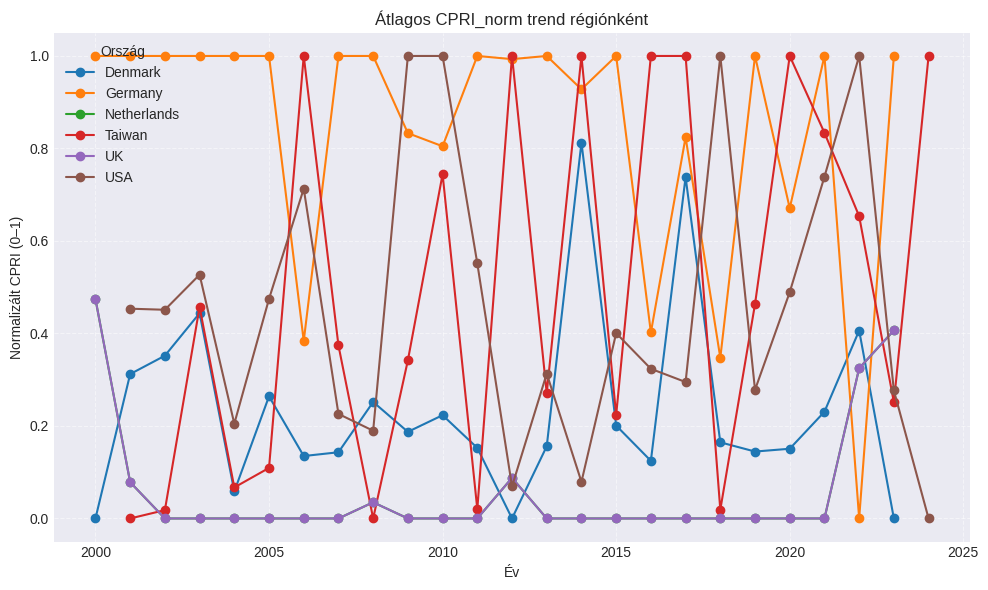

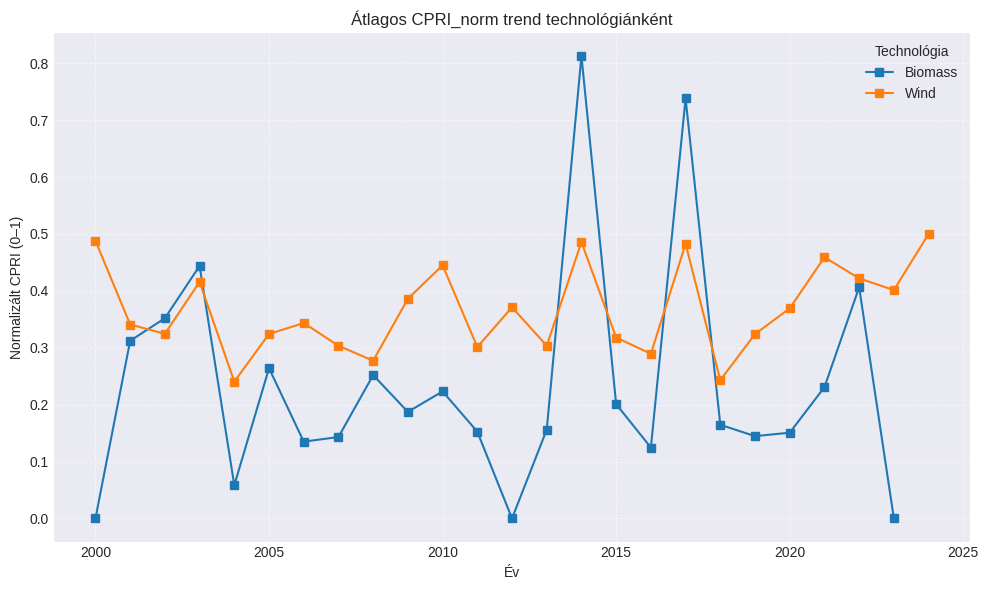

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1️⃣ Beolvasás ----
df = pd.read_csv("/content/cpri_outputs/cpri_index_rebuilt.csv")
assets = pd.read_excel("/content/assets.xlsx")

# Az asset-információk hozzákapcsolása (régió / technológia szerint)
merged = pd.merge(df, assets[['asset_id', 'country', 'type', 'subtype']], on='asset_id', how='left')

# ---- 2️⃣ Régió szintű átlagos CPRI trend ----
region_trend = (
    merged.groupby(['country', 'year'], as_index=False)
    .agg({'CPRI_norm': 'mean'})
    .sort_values(['country', 'year'])
)

plt.figure(figsize=(10,6))
for country, sub in region_trend.groupby('country'):
    plt.plot(sub['year'], sub['CPRI_norm'], marker='o', label=country)

plt.title("Átlagos CPRI_norm trend régiónként")
plt.xlabel("Év")
plt.ylabel("Normalizált CPRI (0–1)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Ország")
plt.tight_layout()
plt.savefig("/content/CPRI_trend_country.png", dpi=300)
plt.show()

# ---- 3️⃣ Technológia szintű trend (opcionális) ----
tech_trend = (
    merged.groupby(['type', 'year'], as_index=False)
    .agg({'CPRI_norm': 'mean'})
    .sort_values(['type', 'year'])
)

plt.figure(figsize=(10,6))
for tech, sub in tech_trend.groupby('type'):
    plt.plot(sub['year'], sub['CPRI_norm'], marker='s', label=tech)

plt.title("Átlagos CPRI_norm trend technológiánként")
plt.xlabel("Év")
plt.ylabel("Normalizált CPRI (0–1)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Technológia")
plt.tight_layout()
plt.savefig("/content/CPRI_trend_technology.png", dpi=300)
plt.show()


✅ Beolvasott assetek: 26, adatsorok: 1608
🌎 Országnevek egységesítve: ['dania', 'nemet', 'tajvan', 'uk', 'usa']
✅ Új r_values_enhanced.csv mentve (1800 sor)
✅ Új cpri_index_rebuilt.csv mentve (600 sor)

📊 Minta:
  asset_id  year  CPRI_index  CPRI_norm
0   DE-001  2000         NaN        NaN
1   DE-001  2001         NaN        NaN
2   DE-001  2002         NaN        NaN
3   DE-001  2003         NaN        NaN
4   DE-001  2004         NaN        NaN
5   DE-001  2005         NaN        NaN
6   DE-001  2006         NaN        NaN
7   DE-001  2007         NaN        NaN
8   DE-001  2008         NaN        NaN
9   DE-001  2009         NaN        NaN


/tmp/ipython-input-635106789.py:117: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


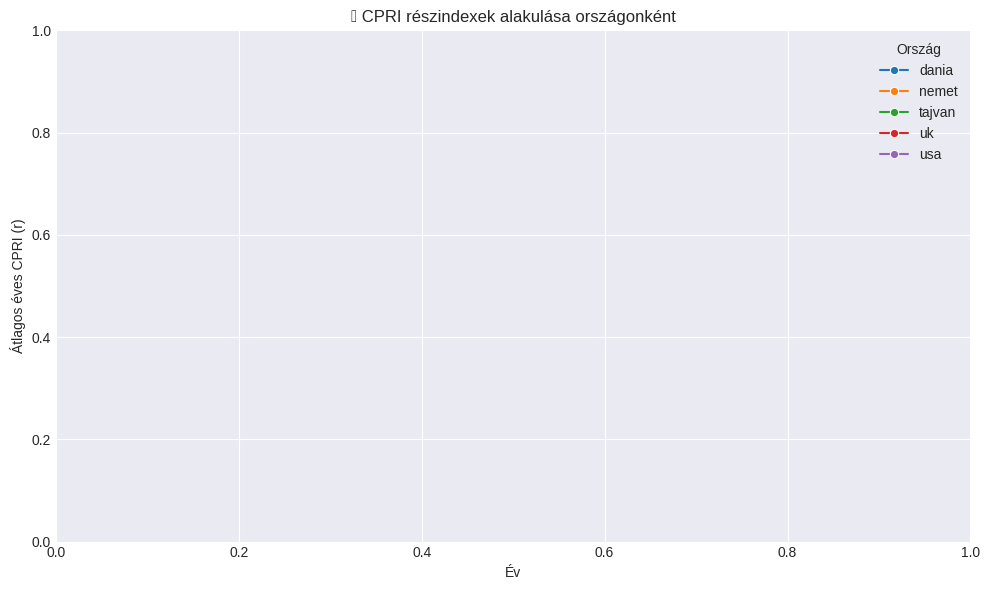

/tmp/ipython-input-635106789.py:131: UserWarning: Glyph 9881 (\N{GEAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-635106789.py:131: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9881 (\N{GEAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


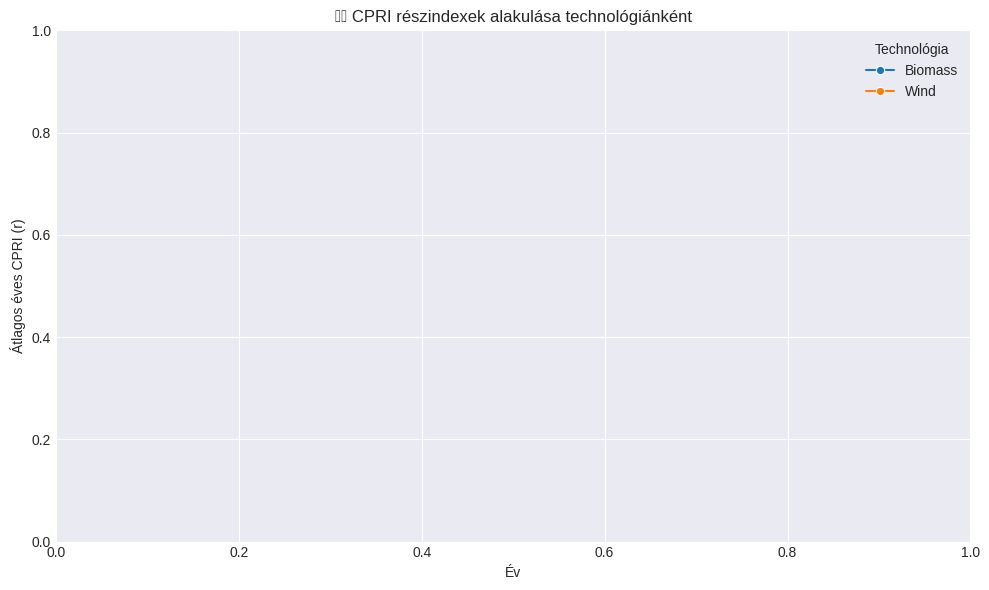

In [ ]:
# ============================================
# 🌍 CPRI ÚJRASZÁMÍTÁS EGYSÉGESÍTETT FORMÁBAN
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---- 1️⃣ Bemeneti fájlok ----
COMBINED_CSV = "/content/combined_cpri_data.csv"
ASSETS_XLSX = "/content/assets.xlsx"
OUTPUT_PATH = "/content/cpri_outputs_fixed"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# ---- 2️⃣ Beolvasás ----
combined = pd.read_csv(COMBINED_CSV)
assets = pd.read_excel(ASSETS_XLSX)

print(f"✅ Beolvasott assetek: {assets.shape[0]}, adatsorok: {combined.shape[0]}")

# ---- 3️⃣ Országnevek egységesítése ----
region_map = {
    'denmark': 'dania',
    'dk': 'dania',
    'germany': 'nemet',
    'de': 'nemet',
    'taiwan': 'tajvan',
    'tw': 'tajvan',
    'uk': 'uk',
    'england': 'uk',
    'united kingdom': 'uk',
    'gb': 'uk',
    'usa': 'usa',
    'us': 'usa',
    'america': 'usa'
}

def normalize_region(x):
    if pd.isna(x): return x
    x = str(x).strip().lower()
    return region_map.get(x, x)

# alkalmazás mindkét adatforrásra
if 'country' in assets.columns:
    assets['country'] = assets['country'].apply(normalize_region)
if 'region' in combined.columns:
    combined['region'] = combined['region'].apply(normalize_region)

print(f"🌎 Országnevek egységesítve: {sorted(combined['region'].dropna().unique())}")

# ---- 4️⃣ r_values_enhanced újraszámítás ----
results = []
for _, a in assets.iterrows():
    country = a['country']
    subset = combined[combined['region'] == country]
    if subset.empty:
        continue

    for _, row in subset.iterrows():
        year = row['year']
        hazard = row['hazard']
        H = row.get('H_norm', np.nan)
        P = row.get('P_norm', np.nan)
        E = row.get('E', 1.0)
        V = row.get('V', 0.5)
        r = H * P * E * V
        results.append({
            'asset_id': a['asset_id'],
            'country': country,
            'hazard': hazard,
            'year': year,
            'H_norm': H,
            'P_norm': P,
            'E': E,
            'V': V,
            'r': r
        })

df_r = pd.DataFrame(results)
df_r.to_csv(os.path.join(OUTPUT_PATH, "r_values_enhanced.csv"), index=False)
print(f"✅ Új r_values_enhanced.csv mentve ({df_r.shape[0]} sor)")

# ---- 5️⃣ CPRI aggregáció (éves átlag minden assetre) ----
df_cpri = (
    df_r.groupby(['asset_id', 'year'])
    .agg({'r': 'mean'})
    .reset_index()
    .rename(columns={'r': 'CPRI_index'})
)

# Normalizálás 0–1 közé
df_cpri['CPRI_norm'] = (df_cpri['CPRI_index'] - df_cpri['CPRI_index'].min()) / (
    df_cpri['CPRI_index'].max() - df_cpri['CPRI_index'].min()
)

df_cpri.to_csv(os.path.join(OUTPUT_PATH, "cpri_index_rebuilt.csv"), index=False)
print(f"✅ Új cpri_index_rebuilt.csv mentve ({df_cpri.shape[0]} sor)")

# ---- 6️⃣ Ellenőrzés ----
print("\n📊 Minta:")
print(df_cpri.head(10))

# ---- 7️⃣ Vizualizáció ----
plt.style.use("seaborn-v0_8-darkgrid")

# CPRI trend országonként
df_r_country = df_r.groupby(['country', 'year'])['r'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_r_country, x='year', y='r', hue='country', marker='o')
plt.title("🌍 CPRI részindexek alakulása országonként")
plt.ylabel("Átlagos éves CPRI (r)")
plt.xlabel("Év")
plt.legend(title='Ország')
plt.tight_layout()
plt.show()

# CPRI technológiánként
if 'type' in assets.columns:
    df_r_tech = df_r.merge(assets[['asset_id', 'type']], on='asset_id', how='left')
    df_r_tech = df_r_tech.groupby(['type', 'year'])['r'].mean().reset_index()

    plt.figure(figsize=(10,6))
    sns.lineplot(data=df_r_tech, x='year', y='r', hue='type', marker='o')
    plt.title("⚙️ CPRI részindexek alakulása technológiánként")
    plt.ylabel("Átlagos éves CPRI (r)")
    plt.xlabel("Év")
    plt.legend(title='Technológia')
    plt.tight_layout()
    plt.show()


In [ ]:
# =====================================================
# 🩵 GYORS JAVÍTÁS: Országnevek kétirányú megfeleltetése
# =====================================================

import pandas as pd
import numpy as np
import os

COMBINED_CSV = "/content/combined_cpri_data.csv"
ASSETS_XLSX = "/content/assets.xlsx"
OUTPUT_PATH = "/content/cpri_outputs_fixed"

combined = pd.read_csv(COMBINED_CSV)
assets = pd.read_excel(ASSETS_XLSX)

print(f"Beolvasva: combined={combined.shape}, assets={assets.shape}")

# --- kétirányú ország megfeleltetés ---
region_map = {
    'denmark': 'dania', 'dk': 'dania', 'dania': 'dania',
    'germany': 'nemet', 'de': 'nemet', 'nemet': 'nemet',
    'taiwan': 'tajvan', 'tw': 'tajvan', 'tajvan': 'tajvan',
    'uk': 'uk', 'united kingdom': 'uk', 'england': 'uk', 'gb': 'uk',
    'usa': 'usa', 'us': 'usa', 'america': 'usa', 'egyesult allamok': 'usa'
}

# mindkét irányra kiterjesztett mapping
rev_map = {v: k for k, v in region_map.items()}
merged_map = {**region_map, **rev_map}

def normalize_country(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().lower()
    return merged_map.get(x, x)

assets['country'] = assets['country'].apply(normalize_country)
combined['region'] = combined['region'].apply(normalize_country)

print("Országnevek (assets):", assets['country'].unique())
print("Országnevek (combined):", combined['region'].unique())

# --- újracsatlakoztatás és számítás ---
results = []
for _, a in assets.iterrows():
    country = a['country']
    subset = combined[combined['region'] == country]
    if subset.empty:
        print(f"⚠️ Üres rész: {country}")
        continue
    for _, row in subset.iterrows():
        H = row.get('H_norm', np.nan)
        P = row.get('P_norm', np.nan)
        E = row.get('E', 1.0)
        V = row.get('V', 0.5)
        r = H * P * E * V
        results.append({
            'asset_id': a['asset_id'],
            'country': country,
            'hazard': row['hazard'],
            'year': row['year'],
            'H_norm': H,
            'P_norm': P,
            'E': E,
            'V': V,
            'r': r
        })

df_r = pd.DataFrame(results)
df_r.to_csv(os.path.join(OUTPUT_PATH, "r_values_enhanced_fixed.csv"), index=False)
print(f"✅ Mentve: r_values_enhanced_fixed.csv ({df_r.shape[0]} sor)")

# --- aggregált CPRI ---
df_cpri = (
    df_r.groupby(['asset_id', 'year'])
    .agg({'r': 'mean'})
    .reset_index()
    .rename(columns={'r': 'CPRI_index'})
)
df_cpri['CPRI_norm'] = (df_cpri['CPRI_index'] - df_cpri['CPRI_index'].min()) / (
    df_cpri['CPRI_index'].max() - df_cpri['CPRI_index'].min()
)
df_cpri.to_csv(os.path.join(OUTPUT_PATH, "cpri_index_rebuilt_fixed.csv"), index=False)
print(f"✅ Mentve: cpri_index_rebuilt_fixed.csv ({df_cpri.shape[0]} sor)")

print("\n📊 Minta:")
print(df_cpri.head(10))


Beolvasva: combined=(1320, 21), assets=(20, 11)
Országnevek (assets): ['dania' 'gb' 'nemet' 'netherlands' 'tajvan' 'egyesult allamok']
Országnevek (combined): ['gb' 'nemet' 'egyesult allamok' 'tajvan' 'dania' nan]
⚠️ Üres rész: netherlands
✅ Mentve: r_values_enhanced_fixed.csv (1368 sor)
✅ Mentve: cpri_index_rebuilt_fixed.csv (456 sor)

📊 Minta:
  asset_id  year  CPRI_index  CPRI_norm
0   DE-001  2000         NaN        NaN
1   DE-001  2001         NaN        NaN
2   DE-001  2002         NaN        NaN
3   DE-001  2003         NaN        NaN
4   DE-001  2004         NaN        NaN
5   DE-001  2005         NaN        NaN
6   DE-001  2006         NaN        NaN
7   DE-001  2007         NaN        NaN
8   DE-001  2008         NaN        NaN
9   DE-001  2009         NaN        NaN


In [ ]:
# Colab cella: assets_complete létrehozása a bemásolt három blokk alapján
import pandas as pd
import os

OUTPUT_DIR = "/content"
OUT_CSV = os.path.join(OUTPUT_DIR, "assets_complete.csv")
OUT_XLSX = os.path.join(OUTPUT_DIR, "assets_complete.xlsx")

# ----- 1) Az asset-ek listája (ez a te beillesztett 3 blokkból épül fel) -----
rows = [
    # ----- első blokk (DK-001..DK-004, UK-001..UK-006) -----
    {"asset_id":"DK-001","name":"Horns Rev 1","country":"Denmark","type":"Wind","subtype":"Offshore","capacity_MW":160,"commission_year":2002,"latitude":55.59,"longitude":7.52},
    {"asset_id":"DK-002","name":"Horns Rev 2","country":"Denmark","type":"Wind","subtype":"Offshore","capacity_MW":209,"commission_year":2009,"latitude":55.55,"longitude":7.45},
    {"asset_id":"DK-003","name":"Horns Rev 3","country":"Denmark","type":"Wind","subtype":"Offshore","capacity_MW":406,"commission_year":2019,"latitude":55.59,"longitude":7.40},
    {"asset_id":"DK-004","name":"Anholt","country":"Denmark","type":"Wind","subtype":"Offshore","capacity_MW":400,"commission_year":2013,"latitude":56.59,"longitude":11.11},
    {"asset_id":"UK-001","name":"London Array","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":630,"commission_year":2013,"latitude":51.63,"longitude":1.46},
    {"asset_id":"UK-002","name":"Walney Extension","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":659,"commission_year":2018,"latitude":54.07,"longitude":-3.63},
    {"asset_id":"UK-003","name":"Hornsea One","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":1218,"commission_year":2020,"latitude":53.94,"longitude":1.74},
    {"asset_id":"UK-004","name":"Hornsea Two","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":1386,"commission_year":2022,"latitude":53.80,"longitude":1.61},
    {"asset_id":"UK-005","name":"Burbo Bank","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":90,"commission_year":2007,"latitude":53.49,"longitude":-3.26},
    {"asset_id":"UK-006","name":"Barrow","country":"UK","type":"Wind","subtype":"Offshore","capacity_MW":90,"commission_year":2006,"latitude":54.10,"longitude":-3.27},
    # ----- második blokk (DE-001..DE-004, NL-001, TW-001..TW-003) -----
    {"asset_id":"DE-001","name":"Borkum Riffgrund 1","country":"Germany","type":"Wind","subtype":"Offshore","capacity_MW":312,"commission_year":2015,"latitude":54.18,"longitude":6.33},
    {"asset_id":"DE-002","name":"Borkum Riffgrund 2","country":"Germany","type":"Wind","subtype":"Offshore","capacity_MW":464,"commission_year":2019,"latitude":54.13,"longitude":6.39},
    {"asset_id":"DE-003","name":"Gode Wind 1","country":"Germany","type":"Wind","subtype":"Offshore","capacity_MW":330,"commission_year":2017,"latitude":54.10,"longitude":6.00},
    {"asset_id":"DE-004","name":"Gode Wind 2","country":"Germany","type":"Wind","subtype":"Offshore","capacity_MW":252,"commission_year":2017,"latitude":54.08,"longitude":6.04},
    {"asset_id":"NL-001","name":"Borssele 1 & 2","country":"Netherlands","type":"Wind","subtype":"Offshore","capacity_MW":752,"commission_year":2020,"latitude":51.63,"longitude":3.09},
    {"asset_id":"TW-001","name":"Formosa 1","country":"Taiwan","type":"Wind","subtype":"Offshore","capacity_MW":128,"commission_year":2019,"latitude":24.43,"longitude":120.68},
    {"asset_id":"TW-002","name":"Greater Changhua 1 & 2a","country":"Taiwan","type":"Wind","subtype":"Offshore","capacity_MW":900,"commission_year":2022,"latitude":24.37,"longitude":120.67},
    {"asset_id":"TW-003","name":"Changhua 2b & 4","country":"Taiwan","type":"Wind","subtype":"Offshore","capacity_MW":920,"commission_year":2025,"latitude":24.30,"longitude":120.70},
    # ----- harmadik blokk (US-001..US-003, DK-005..DK-009) -----
    {"asset_id":"US-001","name":"Block Island","country":"USA","type":"Wind","subtype":"Offshore","capacity_MW":30,"commission_year":2016,"latitude":41.10,"longitude":-71.50},
    {"asset_id":"US-002","name":"South Fork","country":"USA","type":"Wind","subtype":"Offshore","capacity_MW":130,"commission_year":2024,"latitude":40.95,"longitude":-72.22},
    {"asset_id":"US-003","name":"Revolution Wind","country":"USA","type":"Wind","subtype":"Offshore","capacity_MW":704,"commission_year":2025,"latitude":41.19,"longitude":-71.06},
    {"asset_id":"DK-005","name":"Avedøre CHP","country":"Denmark","type":"Biomass","subtype":"Onshore","capacity_MW":810,"commission_year":2001,"latitude":55.60,"longitude":12.40},
    {"asset_id":"DK-006","name":"Asnæs Power Station","country":"Denmark","type":"Biomass","subtype":"Onshore","capacity_MW":640,"commission_year":2020,"latitude":55.67,"longitude":11.10},
    {"asset_id":"DK-007","name":"Skærbæk CHP","country":"Denmark","type":"Biomass","subtype":"Onshore","capacity_MW":392,"commission_year":2019,"latitude":55.56,"longitude":9.60},
    {"asset_id":"DK-008","name":"Studstrup CHP","country":"Denmark","type":"Biomass","subtype":"Onshore","capacity_MW":380,"commission_year":2016,"latitude":56.18,"longitude":10.25},
    {"asset_id":"DK-009","name":"Herning CHP","country":"Denmark","type":"Biomass","subtype":"Onshore","capacity_MW":90,"commission_year":1982,"latitude":56.15,"longitude":9.00},
]

# ----- 2) DataFrame létrehozás, típusok ellenőrzése -----
df = pd.DataFrame(rows, columns=["asset_id","name","country","type","subtype","capacity_MW","commission_year","latitude","longitude"])

# típus-konverziók
df['capacity_MW'] = pd.to_numeric(df['capacity_MW'], errors='coerce')
df['commission_year'] = pd.to_numeric(df['commission_year'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# duplikátum ellenőrzés asset_id szerint
dupes = df[df.duplicated(subset=['asset_id'], keep=False)]
if not dupes.empty:
    print("⚠️ Figyelem: duplikált asset_id-k találhatók:")
    print(dupes)

# ----- 3) Mentés CSV és XLSX formátumban -----
df.to_csv(OUT_CSV, index=False)
df.to_excel(OUT_XLSX, index=False)

# ----- 4) Rövid összefoglaló -----
print("✅ assets_complete létrehozva és mentve:")
print(" - CSV:", OUT_CSV)
print(" - XLSX:", OUT_XLSX)
print("\nÖsszes asset:", len(df))
print("\nOrszágonkénti megoszlás:")
print(df['country'].value_counts(dropna=False))
print("\nTechnológia megoszlás:")
print(df['type'].value_counts(dropna=False))
print("\nElső 10 sor:")
print(df.head(10))


✅ assets_complete létrehozva és mentve:
 - CSV: /content/assets_complete.csv
 - XLSX: /content/assets_complete.xlsx

Összes asset: 26

Országonkénti megoszlás:
country
Denmark        9
UK             6
Germany        4
Taiwan         3
USA            3
Netherlands    1
Name: count, dtype: int64

Technológia megoszlás:
type
Wind       21
Biomass     5
Name: count, dtype: int64

Első 10 sor:
  asset_id              name  country  type   subtype  capacity_MW  \
0   DK-001       Horns Rev 1  Denmark  Wind  Offshore          160   
1   DK-002       Horns Rev 2  Denmark  Wind  Offshore          209   
2   DK-003       Horns Rev 3  Denmark  Wind  Offshore          406   
3   DK-004            Anholt  Denmark  Wind  Offshore          400   
4   UK-001      London Array       UK  Wind  Offshore          630   
5   UK-002  Walney Extension       UK  Wind  Offshore          659   
6   UK-003       Hornsea One       UK  Wind  Offshore         1218   
7   UK-004       Hornsea Two       UK  Wind  Of

In [ ]:
import pandas as pd
import glob
import os

# --- Beállítások ---

INPUT_PATH = "/content/"          # ahol a *_daily_light.csv fájlok vannak
OUTPUT_PATH = "/content/"         # ide mentjük az egyesített verziókat

# --- Megkeressük az összes releváns fájlt ---

files = glob.glob(os.path.join(INPUT_PATH, "*_daily_light.csv"))

print(f"Talált fájlok száma: {len(files)}")

if not files:
    print("⚠️ Nincs megfelelő fájl a megadott mappában!")
else:
    # --- Feldolgozás ---
    for f in files:
        base = os.path.basename(f)
        out_name = base.replace("_daily_light.csv", "_daily_merged.csv")
        out_path = os.path.join(OUTPUT_PATH, out_name)

        print(f"\n📄 Feldolgozás: {base}")
        df = pd.read_csv(f)
        print(f"Eredeti sorok: {len(df)}")

        # Egyesítés dátum szerint – ha ugyanarra a napra két sor van, átlagoljuk
        df_merged = (
            df.groupby("date", as_index=False)
              .mean(numeric_only=True)
        )

        print(f"Egyesítés után: {len(df_merged)} sor")
        df_merged.to_csv(out_path, index=False)
        print(f"✅ Mentve: {out_path}")

    # --- Ellenőrzés ---
    print("\n🎯 Feldolgozás kész! Létrejött fájlok:")
    for m in glob.glob(os.path.join(OUTPUT_PATH, "*_merged.csv")):
        print("  •", os.path.basename(m))

Talált fájlok száma: 5

📄 Feldolgozás: usa_daily_light.csv
Eredeti sorok: 28490
Egyesítés után: 8766 sor
✅ Mentve: /content/usa_daily_merged.csv

📄 Feldolgozás: tajvan_daily_light.csv
Eredeti sorok: 26298
Egyesítés után: 8766 sor
✅ Mentve: /content/tajvan_daily_merged.csv

📄 Feldolgozás: uk_daily_light.csv
Eredeti sorok: 17532
Egyesítés után: 8766 sor
✅ Mentve: /content/uk_daily_merged.csv

📄 Feldolgozás: dania_daily_light.csv
Eredeti sorok: 17532
Egyesítés után: 8766 sor
✅ Mentve: /content/dania_daily_merged.csv

📄 Feldolgozás: nemet_daily_light.csv
Eredeti sorok: 17532
Egyesítés után: 8766 sor
✅ Mentve: /content/nemet_daily_merged.csv

🎯 Feldolgozás kész! Létrejött fájlok:
  • uk_daily_merged.csv
  • usa_daily_merged.csv
  • nemet_daily_merged.csv
  • dania_daily_merged.csv
  • tajvan_daily_merged.csv
